<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN con el cancionero de _Eminem_

Se continúa probando con el cancionero de Eminem, empleado en el desafío 3.

A partir del ejercicio visto en clase, se evaluaron diferentes métodos de implementación de redes neuronales recurrentes (RNN), en función de las performance que pueden ofrecer. Dada una frase, el objetivo es porder predecir la próxima palabra.  

Las pruebas estuvieron en torno a tres ejes:
- Cantidad de capas o neuronaes
- cantidad de épocas
- Agregar BRNN.  

Hay que tener en cuenta que las letras de Eminem tienen una alta carga de giros idiomáticos y dialéctos propios del género del rap.


In [23]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Descarga del dataset.

In [24]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [25]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/eminem.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,"Look, I was gonna go easy on you and not to hu..."
1,But I'm only going to get this one chance
2,"Something's wrong, I can feel it (Six minutes,..."
3,"Just a feeling I've got, like something's abou..."
4,"If that means, what I think it means, we're in..."


In [26]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 6812


### 2 - Preprocesamiento 
Pasos a tener en cuenta:
- Transformación de las oraciones en tokens.
- Ajuste de las oraciones al tamaño fijo de nuestra sentencia de entrada al modelo.
- Separación de las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [27]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [28]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Look, I was gonna go easy on you and not to hu...
1             But I'm only going to get this one chance
2     Something's wrong, I can feel it (Six minutes,...
3     Just a feeling I've got, like something's abou...
4     If that means, what I think it means, we're in...
5     And if he is as bananas as you say, I'm not ta...
6     You were just what the doctor ordered I'm begi...
7     All my people from the front to the back nod, ...
8     Now who thinks their arms are long enough to s...
9     They said I rap like a robot, so call me Rapbo...
10                     I got a laptop in my back pocket
11                 My pen'll go off when I half-cock it
12                  Got a fat knot from that rap profit
13                   Made a living and a killing off it
14          Ever since Bill Clinton was still in office
15         With Monica Lewinsky feeling on his nut-sack
Name: 0, dtype: object

In [29]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Look, I was gonna go easy on you and not to hurt your feelings But I\'m only going to get this one chance Something\'s wrong, I can feel it (Six minutes, Slim Shady, you\'re on) Just a feeling I\'ve got, like something\'s about to happen, but I don\'t know what If that means, what I think it means, we\'re in trouble, big trouble, And if he is as bananas as you say, I\'m not taking any chances You were just what the doctor ordered I\'m beginning to feel like a Rap God, Rap God All my people from the front to the back nod, back nod Now who thinks their arms are long enough to slap box, slap box? They said I rap like a robot, so call me Rapbot But for me to rap like a computer must be in my genes I got a laptop in my back pocket My pen\'ll go off when I half-cock it Got a fat knot from that rap profit Made a living and a killing off it Ever since Bill Clinton was still in office With Monica Lewinsky feeling on his nut-sack I\'m an MC still as honest But as rude and indecent as all hell s

In [30]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:10]

['look', 'i', 'was', 'gonna', 'go', 'easy', 'on', 'you', 'and', 'not']

In [31]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 64838


In [32]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [33]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:5]

[['look', 'i', 'was', 'gonna'],
 ['i', 'was', 'gonna', 'go'],
 ['was', 'gonna', 'go', 'easy'],
 ['gonna', 'go', 'easy', 'on'],
 ['go', 'easy', 'on', 'you']]

In [34]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:10]

[[106, 1, 37, 99],
 [1, 37, 99, 42],
 [37, 99, 42, 843],
 [99, 42, 843, 19],
 [42, 843, 19, 3],
 [843, 19, 3, 6],
 [19, 3, 6, 38],
 [3, 6, 38, 4],
 [6, 38, 4, 256],
 [38, 4, 256, 21]]

In [35]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 64834


### 3 - Input y target

In [36]:
# Slicing de vectores
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(64834, 3)
(64834,)


In [37]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6114

In [38]:
# valor minimo de y_data_int
min(y_data_int)

1

In [39]:
# Corrección de indíces del vector de label
y_data_int_offset = y_data_int - 1

# One Hot Encoding
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(64834, 6114)

In [40]:
# largo de la secuencia de entrada a la RNN
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [41]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6114

### Modelo base
Este es el modelo de referencia. El objetivo es mejorar su performance.

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              30575     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6114)              201762    
                                                                 
Total params: 285,361
Trainable params: 285,361
Non-trai

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1621/1621 [==============================] - 23s 9ms/step - loss: 6.6851 - accuracy: 0.0353 - val_loss: 6.8551 - val_accuracy: 0.0422
Epoch 2/50
1621/1621 [==============================] - 13s 8ms/step - loss: 6.3455 - accuracy: 0.0359 - val_loss: 6.9159 - val_accuracy: 0.0408
Epoch 3/50
1621/1621 [==============================] - 14s 9ms/step - loss: 6.2092 - accuracy: 0.0367 - val_loss: 7.0331 - val_accuracy: 0.0441
Epoch 4/50
1621/1621 [==============================] - 13s 8ms/step - loss: 6.0112 - accuracy: 0.0421 - val_loss: 7.0737 - val_accuracy: 0.0457
Epoch 5/50
1621/1621 [==============================] - 15s 10ms/step - loss: 5.8132 - accuracy: 0.0473 - val_loss: 7.1626 - val_accuracy: 0.0446
Epoch 6/50
1621/1621 [==============================] - 15s 9ms/step - loss: 5.6727 - accuracy: 0.0523 - val_loss: 7.3752 - val_accuracy: 0.0463
Epoch 7/50
1621/1621 [==============================] - 13s 8ms/step - loss: 5.5492 - accuracy: 0.0563 - val_loss: 7.5524 - val_a

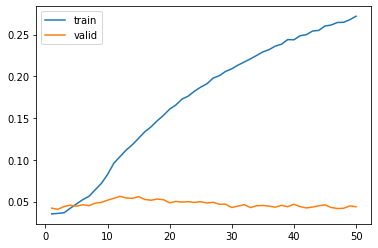

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Modelo cambiando capas y neuronas
Se probaron distintas configuraciones en cuanto a cantidad de capas y neuronas. La presentada fue la que mejor resultados entregó. 

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 5)              30575     
                                                                 
 lstm_10 (LSTM)              (None, 3, 128)            68608     
                                                                 
 dropout_7 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_11 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_8 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_12 (LSTM)              (None, 3, 64)             49408     
                                                                 
 dropout_9 (Dropout)         (None, 3, 64)            

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1621/1621 [==============================] - 27s 13ms/step - loss: 6.6762 - accuracy: 0.0348 - val_loss: 6.8569 - val_accuracy: 0.0422
Epoch 2/50
1621/1621 [==============================] - 21s 13ms/step - loss: 6.4067 - accuracy: 0.0360 - val_loss: 6.9906 - val_accuracy: 0.0426
Epoch 3/50
1621/1621 [==============================] - 20s 13ms/step - loss: 6.2835 - accuracy: 0.0400 - val_loss: 6.9945 - val_accuracy: 0.0456
Epoch 4/50
1621/1621 [==============================] - 21s 13ms/step - loss: 6.0627 - accuracy: 0.0454 - val_loss: 7.0302 - val_accuracy: 0.0502
Epoch 5/50
1621/1621 [==============================] - 21s 13ms/step - loss: 5.8676 - accuracy: 0.0521 - val_loss: 7.1254 - val_accuracy: 0.0490
Epoch 6/50
1621/1621 [==============================] - 21s 13ms/step - loss: 5.7169 - accuracy: 0.0564 - val_loss: 7.2217 - val_accuracy: 0.0518
Epoch 7/50
1621/1621 [==============================] - 20s 13ms/step - loss: 5.5958 - accuracy: 0.0609 - val_loss: 7.3421 -

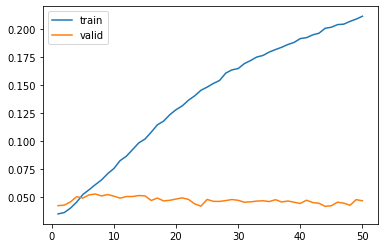

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Modelo cambiando la cantidad de épocas
Se cambia la cantidad de épocas sobre la arquitectura anterior

In [42]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              30575     
                                                                 
 lstm_4 (LSTM)               (None, 3, 128)            68608     
                                                                 
 dropout_3 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_4 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 3, 64)            

In [43]:
hist = model.fit(x_data, y_data, epochs=70, validation_split=0.2)

Epoch 1/70
1621/1621 [==============================] - 56s 29ms/step - loss: 6.6469 - accuracy: 0.0362 - val_loss: 6.8540 - val_accuracy: 0.0422
Epoch 2/70
1621/1621 [==============================] - 46s 29ms/step - loss: 6.3916 - accuracy: 0.0370 - val_loss: 6.9161 - val_accuracy: 0.0362
Epoch 3/70
1621/1621 [==============================] - 45s 28ms/step - loss: 6.2550 - accuracy: 0.0397 - val_loss: 6.8964 - val_accuracy: 0.0372
Epoch 4/70
1621/1621 [==============================] - 44s 27ms/step - loss: 6.0228 - accuracy: 0.0423 - val_loss: 7.0358 - val_accuracy: 0.0446
Epoch 5/70
1621/1621 [==============================] - 44s 27ms/step - loss: 5.8242 - accuracy: 0.0501 - val_loss: 7.1095 - val_accuracy: 0.0486
Epoch 6/70
1621/1621 [==============================] - 45s 28ms/step - loss: 5.6693 - accuracy: 0.0605 - val_loss: 7.2884 - val_accuracy: 0.0548
Epoch 7/70
1621/1621 [==============================] - 44s 27ms/step - loss: 5.5285 - accuracy: 0.0688 - val_loss: 7.3882 -

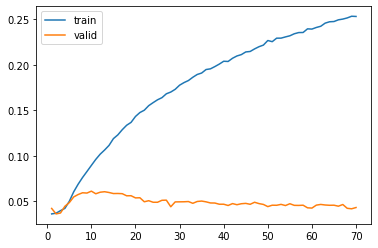

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Conclusiones de modelos implementados
Todos los casos incurren en overfitting. En el caso de arquitecturas, se probaron algunas variaciones, siempre tendiendo a incrementar capas y neuronas, pero empeoraba la situación en validación. El último modelo presentado en este trabajo es el límite de modificación posible, entre lo que se probó. 
En cuanto a la cantidad de épocas, se presenta el mismo inconveniente.

No tiene sentido seguir probando, el inconveniente debe residir en otro punto. 

### Predicción de próxima palabra
Se hará una prueba con el último modelo implementado. 

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

### 6 - Generación de secuencias nuevas

In [48]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [51]:
input_text='You were just what the doctor'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

'You were just what the doctor bananas she'

La frase mencionada es "You were just what the doctor ordered I'm begin...", pero en este caso la finaliza con "bananas she". La mala predicción se debe a los inconvenientes presentados en las conclusiones.